<a href="https://colab.research.google.com/github/dsfsgroup4/customer-sentiment-analysis/blob/main/mcdo_mg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [141]:
import re #pour regex
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#librairies pour model SentimentIntensityAnalyser
import nltk
from nltk.corpus import stopwords #utilisé pour la tokenisation
from nltk.sentiment import SentimentIntensityAnalyzer #le model utilisé
from nltk.tokenize import word_tokenize #le tokenizer
from collections import Counter #pour word count

from wordcloud import WordCloud # éventuellement utile pour visualiser les top thématiques

from transformers import pipeline #pour model DistilBERT

nltk.download('vader_lexicon') #model utilisé
nltk.download('stopwords') #pour tokenisation
nltk.download('punkt_tab') #nécessaire pour la tokenisation


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [142]:
from google.colab import drive

# Monter Google Drive
drive.mount('/content/drive')
!ls '/content/drive/My Drive/Colab Notebooks/Jedha/Projet/McDonald_s_Reviews.csv'
path = "/content/drive/My Drive/Colab Notebooks/Jedha/Projet/McDonald_s_Reviews.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'/content/drive/My Drive/Colab Notebooks/Jedha/Projet/McDonald_s_Reviews.csv'


In [204]:
df = pd.read_csv(path, encoding='latin-1')



In [205]:
df.shape

(33396, 10)

# Découverte du Dataset:

In [159]:
df.columns

Index(['reviewer_id', 'store_name', 'category', 'store_address', 'latitude ',
       'longitude', 'rating_count', 'review_time', 'review', 'rating'],
      dtype='object')

In [145]:
df.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


In [146]:
# compter les enventuels doublons en ignorant la colonne 'reviewer_id' et "rating_count"
len(df)-len(df.drop_duplicates(subset=df.columns.difference(['reviewer_id',"rating_count"])))


8484

In [147]:
df.review[0] #premier commentaire évalué 1 étoile mais attribué positif par le SentimentIntensityAnalyser

'Why does it look like someone spit on my food?\nI had a normal transaction,  everyone was chill and polite, but now i dont want to eat this. Im trying not to think about what this milky white/clear substance is all over my food, i d*** sure am not coming back.'

In [148]:
df.describe(include = "all")
#On constate que des données de latitude et longitude sont manquantes

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
count,33396.000000,33396,33396,33396,32736.000000,32736.000000,33396,33396,33396,33396
unique,NaN,2,1,40,NaN,NaN,51,39,22285,5
top,NaN,McDonald's,Fast food restaurant,"9814 International Dr, Orlando, FL 32819, Unit...",NaN,NaN,"2,193",4 years ago,Excellent,5 stars
freq,NaN,33325,33396,1890,NaN,NaN,1140,6740,2148,10274
mean,16698.500000,NaN,NaN,NaN,34.442546,-90.647033,NaN,NaN,NaN,NaN
std,9640.739131,NaN,NaN,NaN,5.344116,16.594844,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,25.790295,-121.995421,NaN,NaN,NaN,NaN
25%,8349.750000,NaN,NaN,NaN,28.655350,-97.792874,NaN,NaN,NaN,NaN
50%,16698.500000,NaN,NaN,NaN,33.931261,-81.471414,NaN,NaN,NaN,NaN
75%,25047.250000,NaN,NaN,NaN,40.727401,-75.399919,NaN,NaN,NaN,NaN


In [149]:
df[df.isnull().any(axis = 1)].head(3)
#les valeurs longitudes et latitudes manquantes ont également des adresses incorrectes. il faudra donc les supprimer

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
22141,22142,McDonald's,Fast food restaurant,2476 Kalï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿...,NaN,NaN,"2,175",3 months ago,Breakfast specials are good. The sausage burri...,4 stars
22142,22143,McDonald's,Fast food restaurant,2476 Kalï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿...,NaN,NaN,"2,175",a year ago,This isn't your typical McDonald's. This place...,5 stars
22143,22144,McDonald's,Fast food restaurant,2476 Kalï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿...,NaN,NaN,"2,175",2 weeks ago,This place was serving good quality breakfast ...,4 stars


In [150]:
df.store_name.value_counts()
#pas de distinction notable sur les les store_name mal écrits

,count
store_name,
McDonald's,33325
ýýýMcDonald's,71


In [151]:
df[df.store_name=="ýýýMcDonald's"]

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
500,501,ýýýMcDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 years ago,Tasty as usual,5 stars
1000,1001,ýýýMcDonald's,Fast food restaurant,"1698 US-209, Brodheadsville, PA 18322, United ...",40.922081,-75.399919,"1,028",2 years ago,It was good food they got my burger right !!,4 stars
1500,1501,ýýýMcDonald's,Fast food restaurant,"1698 US-209, Brodheadsville, PA 18322, United ...",40.922081,-75.399919,"1,028",4 years ago,Excellent,5 stars
2000,2001,ýýýMcDonald's,Fast food restaurant,"72-69 Kissena Blvd, Queens, NY 11367, United S...",40.727401,-73.812460,"2,193",4 years ago,I never ever ever complain but I've had enough...,1 star
2500,2501,ýýýMcDonald's,Fast food restaurant,"72-69 Kissena Blvd, Queens, NY 11367, United S...",40.727401,-73.812460,"2,193",4 years ago,Fast worker give them props,4 stars
...,...,...,...,...,...,...,...,...,...,...
31255,31256,ýýýMcDonald's,Fast food restaurant,"632 S R L Thornton Freeway Service Rd, Dallas,...",32.744596,-96.812286,"2,658",2 years ago,"Same ol"" ready in 2 minutes food. Idk how they...",2 stars
31755,31756,ýýýMcDonald's,Fast food restaurant,"632 S R L Thornton Freeway Service Rd, Dallas,...",32.744596,-96.812286,"2,658",2 years ago,Unique decor. Bad part of town.,3 stars
32255,32256,ýýýMcDonald's,Fast food restaurant,"632 S R L Thornton Freeway Service Rd, Dallas,...",32.744596,-96.812286,"2,658",2 years ago,ýýýýýýýý Terrible service... they never give y...,1 star
32755,32756,ýýýMcDonald's,Fast food restaurant,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"2,810",5 years ago,They told to wait 7 mnts then she said we are ...,1 star


In [152]:
df.review.sort_values(ascending=False) #des reviews avec des caractères illisibles

,review
6163,ýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýý...
29362,ýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýý
4898,ýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýý ýýý
15018,ýýýýýýýýýýýýýýýýýýýýý
12379,ýýýýýýýýýýýýýýýýýýýý ýýý
...,...
21773,"""24 hour"" store that is closed...."
7110,"!! Fraud location !! !!!Fraud location !!!, th..."
700,waiting time was longer than expected
661,waiting time was longer than expected


# Cleaning

In [206]:
caracteres_speciaux = ["½","ï","ý","Â" , "Ã", "¿","½"]
# Créer une expression régulière à partir de la liste de caractères spéciaux
regex_pattern = '|'.join(caracteres_speciaux)

# Filtrer les lignes contenant l'un des caractères spéciaux
filtered_df = df['review'].str.contains(regex_pattern, na=False)

inverted_filtered_df = ~filtered_df #création d'un mask qui ne conserve que les lignes sans caractères spéciaux

In [207]:
df1 = df.copy(deep = True)

In [208]:
#suppression des lignes avec caractères spéciaux
df1 = df1[inverted_filtered_df]
df1.shape

(30359, 10)

In [209]:
# Supprimer les doublons en ignorant la colonne 'reviewer_id' et "rating_count"
df1 = df1.drop_duplicates(subset=df.columns.difference(['reviewer_id',"rating_count"]))
# réinitialisation de l'index après la suppression des doublons
df1 = df1.reset_index(drop=True)
df1.shape

(22506, 10)

In [210]:
df1 = df1.dropna() #retirer les lignes sans latitude / longitude car leur adresse est invalide
df1.shape

(21912, 10)

In [211]:
# Drop columns 'reviewer_id', 'store_name', 'category', rating_count
df1 = df1.drop(columns=['reviewer_id','store_name', 'category', "rating_count"])


In [212]:
#ajout des colonnes city et state
df1[['City', 'State']] = df1['store_address'].apply(lambda x: pd.Series(x.split(', ')[-3:-1]))



In [213]:
#conserver que les deux initiales de l'Etat
df1["State"]=df1['State'].str.slice(0, 2)

In [214]:
#simplification de l'affichage du rating pour ne conserver que le chiffre
df1["rating"] = (df1["rating"].str.split(" ").str[0].astype(int))


In [215]:
#création d'une colonne avec la date
from datetime import datetime
from dateutil.relativedelta import relativedelta

def parse_relative_date(s, current_date):
    # Remove extra whitespace and split the string
    parts = s.strip().split()
    if len(parts) != 3:
        return None
    # Check if the number is represented as "a" or "an"
    num_str = parts[0].lower()
    if num_str in ['a', 'an']:
        num = 1
    else:
        try:
            num = int(num_str)
        except ValueError:
            return None

    unit = parts[1].lower()

    # Adjust the current date based on the unit
    if 'day' in unit:
        abs_date = current_date - pd.Timedelta(days=num)
    elif 'month' in unit:
        abs_date = current_date - relativedelta(months=num)
    elif 'year' in unit:
        abs_date = current_date - relativedelta(years=num)
    else:
        return None

    # Normalize to remove the time (sets time to 00:00:00)
    return abs_date.normalize()

#Get the current date
current_date = pd.Timestamp.now()

#Apply the function to create a new column with the actual dates
df1['review_date'] = df1['review_time'].apply(lambda x: parse_relative_date(x, current_date))


In [216]:
def clean_review(review):
    review = review.lower()
    review = re.sub(r'[^a-zA-Z\s]', '', review) # retirer les caractères spéciaux
    review = re.sub(r'\s+', ' ', review).strip() # retirer les espaces
    review = re.sub(r'http\S+|www\S+', '', review) # retirer les URLs

    #stop_words = set(stopwords.words('english'))
    #review_tokens = nltk.word_tokenize(review) #methode de tokenisation efficace pour le langage courant (contractions de mots, ponctuation...)
    #mot_a_sup = ["mcdonalds", "one"] #mots trop fréquents dans les commentaires
    #stop_words.update(mot_a_sup)
    #review = ' '.join([word for word in review_tokens if word not in stop_words])


    return review

df1['clean_reviews'] = df1['review'].apply(clean_review)


In [217]:
'''
# Supprimer les review de plus de 5 caractères en doublons (limoite à 5 car on considère qu'un commentaire court peut être fait par plusieures personnes)
reviews_more_than_5_words = df1[df1['review'].apply(lambda x: len(x.split()) > 5)]
reviews_less_than_5_words = df1[df1['review'].apply(lambda x: len(x.split()) <= 5)]

reviews_unique = reviews_more_than_5_words.drop_duplicates(subset='review')

df1 = pd.concat([reviews_unique, reviews_less_than_5_words], ignore_index=True)
df1.shape
'''

#cleaning remplacé par la suppression des doublons au niveau global


"\n# Supprimer les review de plus de 5 caractères en doublons (limoite à 5 car on considère qu'un commentaire court peut être fait par plusieures personnes)\nreviews_more_than_5_words = df1[df1['review'].apply(lambda x: len(x.split()) > 5)]\nreviews_less_than_5_words = df1[df1['review'].apply(lambda x: len(x.split()) <= 5)]\n\nreviews_unique = reviews_more_than_5_words.drop_duplicates(subset='review')\n\ndf1 = pd.concat([reviews_unique, reviews_less_than_5_words], ignore_index=True)\ndf1.shape\n"

In [218]:
def tokenizer(review):
    stop_words = set(stopwords.words('english'))
    review_tokens = nltk.word_tokenize(review) #methode de tokenisation efficace pour le langage courant (contractions de mots, ponctuation...)
    mot_a_sup = ["mcdonalds", "one"] #mots trop fréquents dans les commentaires
    stop_words.update(mot_a_sup)
    review = ' '.join([word for word in review_tokens if word not in stop_words])


    return review

df1['clean_reviews_tokenised'] = df1['clean_reviews'].apply(tokenizer)

In [219]:
def liked (data):
    if data['rating'] > 3:
      return "POSITIF"
    elif data["rating"] ==3:
      return "NEUTRE"
    else:
      return "NEGATIF"

df1['liked'] = df1.apply(liked, axis = 1)


In [220]:
df1.head()

,store_address,latitude,longitude,review_time,review,rating,City,State,review_date,clean_reviews,clean_reviews_tokenised,liked
0,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,3 months ago,Why does it look like someone spit on my food?...,1,Austin,TX,2025-01-05,why does it look like someone spit on my food ...,look like someone spit food normal transaction...,NEGATIF
1,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,5 days ago,It'd McDonalds. It is what it is as far as the...,4,Austin,TX,2025-03-31,itd mcdonalds it is what it is as far as the f...,itd far food atmosphere go staff make differen...,POSITIF
2,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,2 months ago,"I repeat my order 3 times in the drive thru, a...",1,Austin,TX,2025-02-05,i repeat my order times in the drive thru and ...,repeat order times drive thru still manage mes...,NEGATIF
3,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,3 weeks ago,I work for door dash and they locked us all ou...,1,Austin,TX,NaT,i work for door dash and they locked us all ou...,work door dash locked us wait long line reason...,NEGATIF
4,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,3 months ago,If I could give this location a zero on custo...,1,Austin,TX,2025-01-05,if i could give this location a zero on custom...,could give location zero customer service woul...,NEGATIF


In [221]:
df1.to_csv("/content/drive/My Drive/Colab Notebooks/Jedha/Projet/df1_cleanning_sans_doublons.csv", index=False)

In [222]:
df1=pd.read_csv("/content/drive/My Drive/Colab Notebooks/Jedha/Projet/df1_cleanning_sans_doublons.csv")

In [223]:
#suppression des null dans les clean_reviews
mask = df1[df1["clean_reviews"].notnull()]
df1 = mask
df1.to_csv("/content/drive/My Drive/Colab Notebooks/Jedha/Projet/df1_cleanning_sans_doublons.csv", index=False)

In [224]:
len(mask)

21910

In [225]:
df1=pd.read_csv("/content/drive/My Drive/Colab Notebooks/Jedha/Projet/df1_cleanning_sans_doublons.csv")
df1.shape

(21910, 12)

# EDA

In [227]:
df1["liked"].value_counts(normalize=True, dropna=False) * 100

,proportion
liked,
POSITIF,46.608854
NEGATIF,38.366043
NEUTRE,15.025103


In [228]:
df1["rating"].value_counts(normalize=True, dropna=False) * 100

,proportion
rating,
5,29.475126
1,28.397992
4,17.133729
3,15.025103
2,9.968051


In [229]:
df1["City"].value_counts(normalize=True, dropna=False) * 100

,proportion
City,
New York,12.076677
Orlando,9.068918
Austin,5.933364
Dallas,4.796896
Miami,4.582382
Queens,4.395253
Las Vegas,4.262894
Los Angeles,4.253765
San Diego,4.244637


In [230]:
df1["State"].value_counts(normalize=True, dropna=False) * 100

,proportion
State,
FL,23.026016
NY,19.073482
TX,17.845733
CA,17.663168
NJ,5.426746
NV,4.262894
UT,3.514377
IL,2.884528
PA,2.528526


# Sentiment analyser

In [231]:
df2 = df1.copy(deep = True)

In [234]:
df2.head(3)

,store_address,latitude,longitude,review_time,review,rating,City,State,review_date,clean_reviews,clean_reviews_tokenised,liked
0,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,3 months ago,Why does it look like someone spit on my food?...,1,Austin,TX,2025-01-05,why does it look like someone spit on my food ...,look like someone spit food normal transaction...,NEGATIF
1,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,5 days ago,It'd McDonalds. It is what it is as far as the...,4,Austin,TX,2025-03-31,itd mcdonalds it is what it is as far as the f...,itd far food atmosphere go staff make differen...,POSITIF
2,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,2 months ago,"I repeat my order 3 times in the drive thru, a...",1,Austin,TX,2025-02-05,i repeat my order times in the drive thru and ...,repeat order times drive thru still manage mes...,NEGATIF


## model SentimentIntensityAnalyser

In [235]:
analyzer = SentimentIntensityAnalyzer()

#Sentiment score compris entre -1 (très négatif) et 1 (très positif)
df2['sentiment_score_SIA'] = df2['clean_reviews_tokenised'].apply(lambda text: analyzer.polarity_scores(str(text))['compound'])
df2['sentiment_SIA'] = None

df2['sentiment_SIA'] = df2['sentiment_score_SIA'].apply(lambda score: 'positive' if score >= 0.4 else ('negative' if score <= -0.1 else 'neutral'))
print(df2[['sentiment_score_SIA', 'sentiment_SIA', 'liked', "review"]].head())

   sentiment_score_SIA sentiment_SIA    liked  \
0               0.5541      positive  NEGATIF   
1               0.8591      positive  POSITIF   
2              -0.7184      negative  NEGATIF   
3              -0.2960      negative  NEGATIF   
4              -0.5667      negative  NEGATIF   

                                              review  
0  Why does it look like someone spit on my food?...  
1  It'd McDonalds. It is what it is as far as the...  
2  I repeat my order 3 times in the drive thru, a...  
3  I work for door dash and they locked us all ou...  
4  If I  could give this location a zero on custo...  


In [236]:
df2["sentiment_SIA"].value_counts(normalize=True, dropna=False) * 100

,proportion
sentiment_SIA,
positive,43.984482
neutral,30.529439
negative,25.486079


In [237]:
#rappel de la répartition des liked pour comparaison
df2["liked"].value_counts(normalize=True, dropna=False) * 100

,proportion
liked,
POSITIF,46.608854
NEGATIF,38.366043
NEUTRE,15.025103


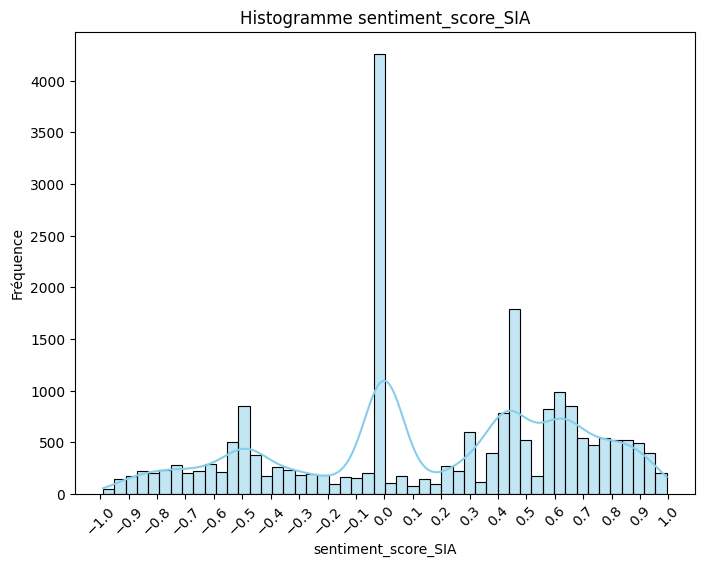

In [238]:
#graphique réalisé pour décider des tranches les plus adaptées pour distinguer positive, negative, neutre
plt.figure(figsize=(8, 6))
sns.histplot(df2["sentiment_score_SIA"], bins=50, kde=True, color='skyblue', edgecolor='black')

plt.xlabel('sentiment_score_SIA')
plt.ylabel('Fréquence')
plt.title('Histogramme sentiment_score_SIA')

plt.xticks(rotation=45)  # Fait pivoter les étiquettes de 45 degrés
plt.xticks(np.arange(-1, 1.1, 0.1))  # Ajoute des graduations tous les 0.1 entre -1 et 1

# Afficher l'histogramme
plt.show()

<Figure size 800x600 with 0 Axes>

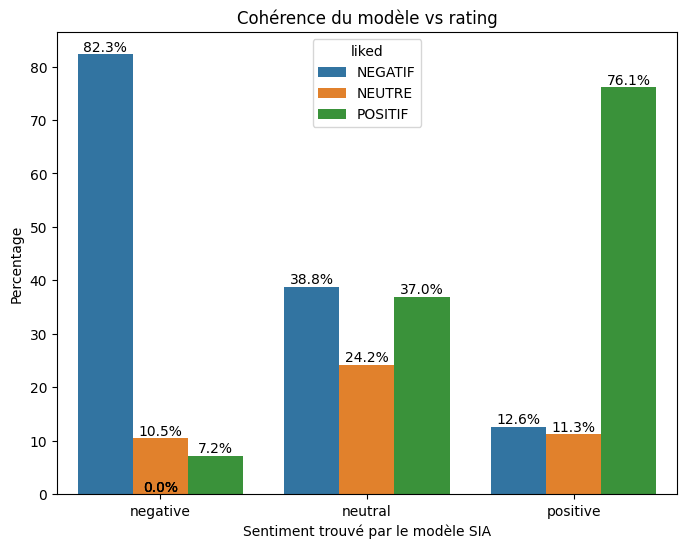

In [239]:
plt.figure(figsize=(8, 6))

# Calculer les pourcentages
rates = df2.groupby(['sentiment_SIA', 'liked']).size().unstack().fillna(0)
rates = rates.div(rates.sum(axis=1), axis=0) * 100

# Convertir les taux en format long pour seaborn
rates_long = rates.reset_index().melt(id_vars='sentiment_SIA', value_name='percentage')

# Créer le diagramme en bâtons avec seaborn
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=rates_long, x='sentiment_SIA', y='percentage', hue='liked')

# Ajouter des annotations
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')


# Ajouter un titre et des labels
plt.title('Cohérence du modèle vs rating')
plt.xlabel('Sentiment trouvé par le modèle SIA')
plt.ylabel('Percentage')
plt.xticks(rotation=0)

# Afficher le graphique
plt.show()



In [240]:
analyzer = SentimentIntensityAnalyzer() #model sans neutres

#Sentiment score compris entre -1 (très négatif) et 1 (très positif)
df2['sentiment_SIA_sans_neutre'] = df2['sentiment_score_SIA'].apply(lambda score: 'positive' if score >= 0.4 else 'negative')
print(df2[['sentiment_score_SIA', 'sentiment_SIA_sans_neutre', 'liked']].head())

   sentiment_score_SIA sentiment_SIA_sans_neutre    liked
0               0.5541                  positive  NEGATIF
1               0.8591                  positive  POSITIF
2              -0.7184                  negative  NEGATIF
3              -0.2960                  negative  NEGATIF
4              -0.5667                  negative  NEGATIF


<Figure size 800x600 with 0 Axes>

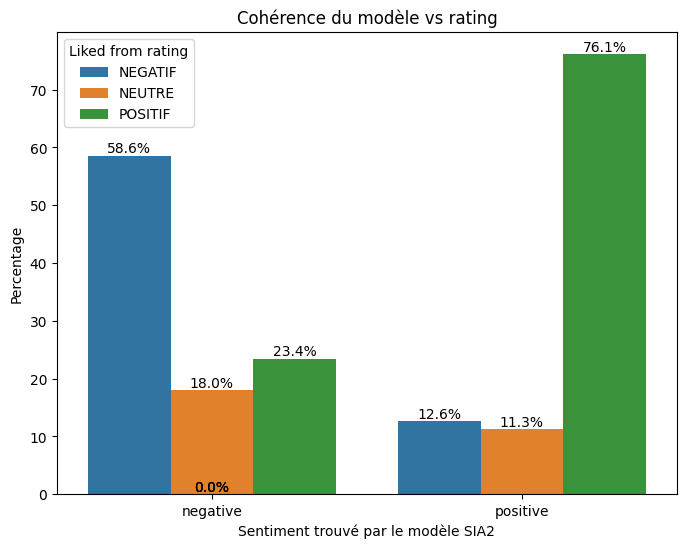

In [241]:
plt.figure(figsize=(8, 6))

# Calculer les pourcentages
rates = df2.groupby(['sentiment_SIA_sans_neutre', 'liked']).size().unstack().fillna(0)
rates = rates.div(rates.sum(axis=1), axis=0) * 100

# Convertir les taux en format long pour seaborn
rates_long = rates.reset_index().melt(id_vars='sentiment_SIA_sans_neutre', value_name='percentage')

# Créer le diagramme en bâtons avec seaborn
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=rates_long, x='sentiment_SIA_sans_neutre', y='percentage', hue='liked')

# Ajouter des annotations
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

# Ajouter un titre et des labels
plt.title('Cohérence du modèle vs rating')
plt.xlabel('Sentiment trouvé par le modèle SIA2')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Liked from rating')

# Afficher le graphique
plt.show()

In [242]:
df2["rating"][df2["sentiment_score_SIA"]>=0.9].value_counts() #on constate que parmi les avis les mieux notés par le model, un certain nombres n'ont que 1, 2 ou 3 étoiles

,count
rating,
5,472
4,167
3,58
1,43
2,20


In [243]:
df2.to_csv("/content/drive/My Drive/Colab Notebooks/Jedha/Projet/df2_model_SIA.csv", index=False)

In [244]:
df2 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Jedha/Projet/df2_model_SIA.csv")
df2.describe(include= "all")

,store_address,latitude,longitude,review_time,review,rating,City,State,review_date,clean_reviews,clean_reviews_tokenised,liked,sentiment_score_SIA,sentiment_SIA,sentiment_SIA_sans_neutre
count,21910,21910.000000,21910.000000,21910,21910,21910.000000,21910,21910,21619,21910,21769,21910,21910.000000,21910,21910
unique,39,NaN,NaN,37,19359,NaN,26,11,29,18855,18267,3,NaN,3,2
top,"632 S R L Thornton Freeway Service Rd, Dallas,...",NaN,NaN,4 years ago,Excellent,NaN,New York,FL,2021-04-05,good,good,POSITIF,NaN,positive,negative
freq,1051,NaN,NaN,4610,295,NaN,2646,5045,4610,346,428,10212,NaN,9637,12273
mean,NaN,34.827979,-91.363012,NaN,NaN,3.093199,NaN,NaN,NaN,NaN,NaN,NaN,0.168967,NaN,NaN
std,NaN,5.402010,17.065779,NaN,NaN,1.605420,NaN,NaN,NaN,NaN,NaN,NaN,0.502218,NaN,NaN
min,NaN,25.790295,-121.995421,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,-0.989900,NaN,NaN
25%,NaN,29.676267,-111.897383,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,-0.102700,NaN,NaN
50%,NaN,34.035270,-81.513738,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.248850,NaN,NaN
75%,NaN,40.729126,-75.399919,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.599400,NaN,NaN


## Model Text_classification from DistilBERT

In [245]:
#test du model distilbert
pipe = pipeline("text-classification", model="distilbert-base-uncased-finetuned-sst-2-english", truncation=True, max_length=512) #model par défaut. tronqué car il ne support pas les reviews de plus de 512 tokens
reviews = df2["review"].tolist()
df2['text_classification'] = pipe(reviews)

Device set to use cpu


In [246]:
for i in df2.index:
    df2.loc[i, "sentiment_TC"] = df2.loc[i, "text_classification"]["label"]
    df2.loc[i, "score_TC"] = df2.loc[i, "text_classification"]["score"]
df2 = df2.drop(["text_classification"],axis = 1)

In [247]:
df2.head()

,store_address,latitude,longitude,review_time,review,rating,City,State,review_date,clean_reviews,clean_reviews_tokenised,liked,sentiment_score_SIA,sentiment_SIA,sentiment_SIA_sans_neutre,sentiment_TC,score_TC
0,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,3 months ago,Why does it look like someone spit on my food?...,1,Austin,TX,2025-01-05,why does it look like someone spit on my food ...,look like someone spit food normal transaction...,NEGATIF,0.5541,positive,positive,NEGATIVE,0.999151
1,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,5 days ago,It'd McDonalds. It is what it is as far as the...,4,Austin,TX,2025-03-31,itd mcdonalds it is what it is as far as the f...,itd far food atmosphere go staff make differen...,POSITIF,0.8591,positive,positive,POSITIVE,0.999840
2,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,2 months ago,"I repeat my order 3 times in the drive thru, a...",1,Austin,TX,2025-02-05,i repeat my order times in the drive thru and ...,repeat order times drive thru still manage mes...,NEGATIF,-0.7184,negative,negative,NEGATIVE,0.999598
3,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,3 weeks ago,I work for door dash and they locked us all ou...,1,Austin,TX,NaN,i work for door dash and they locked us all ou...,work door dash locked us wait long line reason...,NEGATIF,-0.2960,negative,negative,NEGATIVE,0.999387
4,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,3 months ago,If I could give this location a zero on custo...,1,Austin,TX,2025-01-05,if i could give this location a zero on custom...,could give location zero customer service woul...,NEGATIF,-0.5667,negative,negative,NEGATIVE,0.999106


<Figure size 800x600 with 0 Axes>

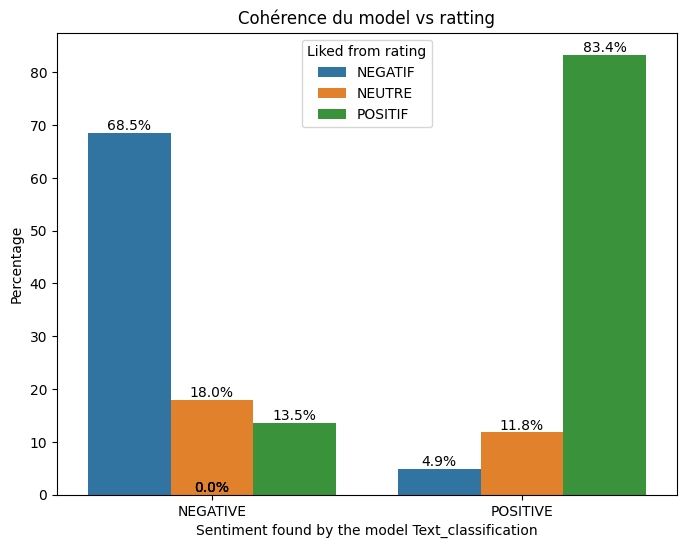

In [248]:
plt.figure(figsize=(8, 6))

# Calculer les pourcentages
rates = df2.groupby(['sentiment_TC', 'liked']).size().unstack().fillna(0)
rates = rates.div(rates.sum(axis=1), axis=0) * 100

# Convertir les taux en format long pour seaborn
rates_long = rates.reset_index().melt(id_vars='sentiment_TC', value_name='percentage')

# Créer le diagramme en bâtons avec seaborn
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=rates_long, x='sentiment_TC', y='percentage', hue='liked')

# Ajouter des annotations
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

plt.title('Cohérence du model vs ratting')
plt.xlabel('Sentiment found by the model Text_classification')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Liked from rating')
plt.show()

on constate une meilleure attribution des commentaires positifs

In [249]:
df2.to_csv("/content/drive/My Drive/Colab Notebooks/Jedha/Projet/df2_model_TC.csv", index=False)

In [250]:
df2= pd.read_csv("/content/drive/My Drive/Colab Notebooks/Jedha/Projet/df2_model_TC.csv")

In [251]:
df2["score_TC"][df2["sentiment_TC"]=="POSITIVE"].describe() #le taux de certainité pour le positif est élevé

,score_TC
count,10378.000000
mean,0.981796
std,0.065291
min,0.500639
25%,0.997853
50%,0.999712
75%,0.999843
max,0.999892


In [252]:
df2["score_TC"][df2["sentiment_TC"]=="NEGATIVE"].describe() #le taux de certainité pour le negatif est élevé

,score_TC
count,11532.000000
mean,0.982792
std,0.060613
min,0.500058
25%,0.995356
50%,0.999085
75%,0.999641
max,0.999832


# model RoBERTa

In [253]:
df3= df2.copy(deep = True)

In [254]:
df3.head()

,store_address,latitude,longitude,review_time,review,rating,City,State,review_date,clean_reviews,clean_reviews_tokenised,liked,sentiment_score_SIA,sentiment_SIA,sentiment_SIA_sans_neutre,sentiment_TC,score_TC
0,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,3 months ago,Why does it look like someone spit on my food?...,1,Austin,TX,2025-01-05,why does it look like someone spit on my food ...,look like someone spit food normal transaction...,NEGATIF,0.5541,positive,positive,NEGATIVE,0.999151
1,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,5 days ago,It'd McDonalds. It is what it is as far as the...,4,Austin,TX,2025-03-31,itd mcdonalds it is what it is as far as the f...,itd far food atmosphere go staff make differen...,POSITIF,0.8591,positive,positive,POSITIVE,0.999840
2,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,2 months ago,"I repeat my order 3 times in the drive thru, a...",1,Austin,TX,2025-02-05,i repeat my order times in the drive thru and ...,repeat order times drive thru still manage mes...,NEGATIF,-0.7184,negative,negative,NEGATIVE,0.999598
3,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,3 weeks ago,I work for door dash and they locked us all ou...,1,Austin,TX,NaN,i work for door dash and they locked us all ou...,work door dash locked us wait long line reason...,NEGATIF,-0.2960,negative,negative,NEGATIVE,0.999387
4,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,3 months ago,If I could give this location a zero on custo...,1,Austin,TX,2025-01-05,if i could give this location a zero on custom...,could give location zero customer service woul...,NEGATIF,-0.5667,negative,negative,NEGATIVE,0.999106


In [255]:
# Load model
from transformers import pipeline

# Initialize the sentiment analysis pipeline
model_roberta = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment")

Device set to use cpu


In [256]:
df3.head(3)

,store_address,latitude,longitude,review_time,review,rating,City,State,review_date,clean_reviews,clean_reviews_tokenised,liked,sentiment_score_SIA,sentiment_SIA,sentiment_SIA_sans_neutre,sentiment_TC,score_TC
0,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,3 months ago,Why does it look like someone spit on my food?...,1,Austin,TX,2025-01-05,why does it look like someone spit on my food ...,look like someone spit food normal transaction...,NEGATIF,0.5541,positive,positive,NEGATIVE,0.999151
1,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,5 days ago,It'd McDonalds. It is what it is as far as the...,4,Austin,TX,2025-03-31,itd mcdonalds it is what it is as far as the f...,itd far food atmosphere go staff make differen...,POSITIF,0.8591,positive,positive,POSITIVE,0.999840
2,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,2 months ago,"I repeat my order 3 times in the drive thru, a...",1,Austin,TX,2025-02-05,i repeat my order times in the drive thru and ...,repeat order times drive thru still manage mes...,NEGATIF,-0.7184,negative,negative,NEGATIVE,0.999598


In [257]:
from tqdm.notebook import tqdm

# Initialiser la colonne "Roberta" avec des dictionnaires vides
df3["Roberta"] = [{} for _ in range(len(df3))]

# Définir la limite de longueur
max_length = 514

# Loop to each review in the dataset, the results are stored in a dictionary
for i, row in tqdm(df3.iterrows(), total=len(df3)):
    try:
        text = row['clean_reviews']
        myid = i  # Utiliser l'index comme identifiant

        # Tronquer le texte si nécessaire
        if len(text) > max_length:
            text = text[:max_length]

        roberta_result = model_roberta(text)
        roberta_result_model = {}

        if isinstance(roberta_result, list) and len(roberta_result) > 0:
            for key, value in roberta_result[0].items():
                roberta_result_model[f'RoBerta_{key}'] = value

        df3.at[i, "Roberta"] = roberta_result_model

    except RuntimeError:
        print(f'Runtime error for id {myid}')

  0%|          | 0/21910 [00:00<?, ?it/s]

In [258]:
df3.to_csv("/content/drive/My Drive/Colab Notebooks/Jedha/Projet/df3_model_Roberta.csv")

In [260]:
df3=pd.read_csv("/content/drive/My Drive/Colab Notebooks/Jedha/Projet/df3_model_Roberta.csv")

In [261]:
df3["Roberta"] = df3["Roberta"].apply(ast.literal_eval)

In [262]:
df3["Roberta"][0]

{'RoBerta_label': 'LABEL_0', 'RoBerta_score': 0.9752793908119202}

In [263]:
df3["RoBerta_label"]=None
df3["RoBerta_score"]=None
# Itérer sur l'index et les valeurs de la colonne "Roberta"
for i, roberta_dict in df3["Roberta"].items():
    # Vérifier si "RoBerta_label" existe dans le dictionnaire
    if "RoBerta_label" in roberta_dict:
        # Mettre à jour la colonne "RoBerta_label" avec la valeur correspondante
        df3.at[i, "RoBerta_label"] = roberta_dict["RoBerta_label"]
        df3.at[i, "RoBerta_score"] = roberta_dict["RoBerta_score"]
df3 = df3.drop("Roberta", axis=1)

In [264]:
# RoBERTa labeled results as: for negative review as LABEL_0, for neutral as LABEL_1, and for positive as LABEL_2
# Below is to map  the Labels as negative , neutral and positive

def map_roberta_labels(label):
    if label == 'LABEL_0':
        return 'negative'
    elif label == 'LABEL_1':
        return 'neutral'
    elif label == 'LABEL_2':
        return 'positive'
    else:
        return 'unknown'

# Apply the function to the 'RoBerta_label' column
df3['RoBerta_label'] = df3['RoBerta_label'].apply(map_roberta_labels)

In [265]:
df3['RoBerta_score'] = df3['RoBerta_score'].astype(float)

In [266]:
df3["RoBerta_score"].describe()

,RoBerta_score
count,21910.000000
mean,0.803986
std,0.169239
min,0.348643
25%,0.661760
50%,0.870344
75%,0.956574
max,0.993091


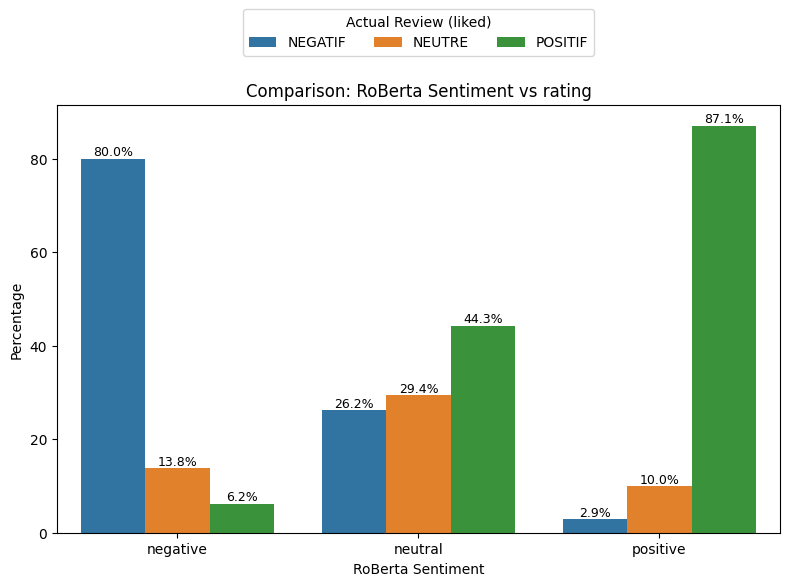

In [267]:
df_refults_filtered = df3.copy()

# Group and compute percentages
rates = df_refults_filtered.groupby(['RoBerta_label', 'liked']).size().unstack().fillna(0)
rates = rates.div(rates.sum(axis=1), axis=0) * 100

# Convert to long format
rates_long = rates.reset_index().melt(id_vars='RoBerta_label', value_name='percentage', var_name='liked')

# Barplot
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=rates_long, x='RoBerta_label', y='percentage', hue='liked')

# Add percentage labels on top of bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.1f}%',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9)

plt.title('Comparison: RoBerta Sentiment vs rating')
plt.xlabel('RoBerta Sentiment')
plt.ylabel('Percentage')
plt.legend(title='Actual Review (liked)', loc='lower center', bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [268]:
df3["RoBerta_label"].value_counts()

,count
RoBerta_label,
positive,9081
negative,8887
neutral,3942


In [ ]:
df3.to_csv("/content/drive/My Drive/Colab Notebooks/Jedha/Projet/df3_model_Roberta_bis.csv")

In [271]:
df3.shape

(21910, 20)

# préparation du dataset pour dashboard

In [272]:
df4 = df3.copy(deep=True)

In [274]:
df4["latitude"]=df4["latitude "]
df4= df4.drop("latitude ", axis = 1)
df4.head()

,Unnamed: 0,store_address,longitude,review_time,review,rating,City,State,review_date,clean_reviews,clean_reviews_tokenised,liked,sentiment_score_SIA,sentiment_SIA,sentiment_SIA_sans_neutre,sentiment_TC,score_TC,RoBerta_label,RoBerta_score,latitude
0,0,"13749 US-183 Hwy, Austin, TX 78750, United States",-97.792874,3 months ago,Why does it look like someone spit on my food?...,1,Austin,TX,2025-01-05,why does it look like someone spit on my food ...,look like someone spit food normal transaction...,NEGATIF,0.5541,positive,positive,NEGATIVE,0.999151,negative,0.975279,30.460718
1,1,"13749 US-183 Hwy, Austin, TX 78750, United States",-97.792874,5 days ago,It'd McDonalds. It is what it is as far as the...,4,Austin,TX,2025-03-31,itd mcdonalds it is what it is as far as the f...,itd far food atmosphere go staff make differen...,POSITIF,0.8591,positive,positive,POSITIVE,0.999840,positive,0.973995,30.460718
2,2,"13749 US-183 Hwy, Austin, TX 78750, United States",-97.792874,2 months ago,"I repeat my order 3 times in the drive thru, a...",1,Austin,TX,2025-02-05,i repeat my order times in the drive thru and ...,repeat order times drive thru still manage mes...,NEGATIF,-0.7184,negative,negative,NEGATIVE,0.999598,negative,0.937037,30.460718
3,3,"13749 US-183 Hwy, Austin, TX 78750, United States",-97.792874,3 weeks ago,I work for door dash and they locked us all ou...,1,Austin,TX,NaN,i work for door dash and they locked us all ou...,work door dash locked us wait long line reason...,NEGATIF,-0.2960,negative,negative,NEGATIVE,0.999387,negative,0.901194,30.460718
4,4,"13749 US-183 Hwy, Austin, TX 78750, United States",-97.792874,3 months ago,If I could give this location a zero on custo...,1,Austin,TX,2025-01-05,if i could give this location a zero on custom...,could give location zero customer service woul...,NEGATIF,-0.5667,negative,negative,NEGATIVE,0.999106,neutral,0.474095,30.460718


In [275]:
df4=df4[["store_address","City","State","longitude","latitude","review_time","review_date","review","clean_reviews","rating","liked","RoBerta_label","RoBerta_score"]]

In [277]:
df4.head()

,store_address,City,State,longitude,latitude,review_time,review_date,review,clean_reviews,rating,liked,RoBerta_label,RoBerta_score
0,"13749 US-183 Hwy, Austin, TX 78750, United States",Austin,TX,-97.792874,30.460718,3 months ago,2025-01-05,Why does it look like someone spit on my food?...,why does it look like someone spit on my food ...,1,NEGATIF,negative,0.975279
1,"13749 US-183 Hwy, Austin, TX 78750, United States",Austin,TX,-97.792874,30.460718,5 days ago,2025-03-31,It'd McDonalds. It is what it is as far as the...,itd mcdonalds it is what it is as far as the f...,4,POSITIF,positive,0.973995
2,"13749 US-183 Hwy, Austin, TX 78750, United States",Austin,TX,-97.792874,30.460718,2 months ago,2025-02-05,"I repeat my order 3 times in the drive thru, a...",i repeat my order times in the drive thru and ...,1,NEGATIF,negative,0.937037
3,"13749 US-183 Hwy, Austin, TX 78750, United States",Austin,TX,-97.792874,30.460718,3 weeks ago,NaN,I work for door dash and they locked us all ou...,i work for door dash and they locked us all ou...,1,NEGATIF,negative,0.901194
4,"13749 US-183 Hwy, Austin, TX 78750, United States",Austin,TX,-97.792874,30.460718,3 months ago,2025-01-05,If I could give this location a zero on custo...,if i could give this location a zero on custom...,1,NEGATIF,neutral,0.474095


In [278]:
df4.columns

Index(['store_address', 'City', 'State', 'longitude', 'latitude',
       'review_time', 'review_date', 'review', 'clean_reviews', 'rating',
       'liked', 'RoBerta_label', 'RoBerta_score'],
      dtype='object')

In [279]:
df4.to_csv("/content/drive/My Drive/Colab Notebooks/Jedha/Projet/df4_model_roberta_pour_dash.csv")

## Model Prompt Engineering (non concluant car limité)

In [280]:
df5 = df4.copy()

### selection des commentaires input

In [281]:
df5["review"][df5["rating"]==5]

,review
24,The staff are very friendly and they do their ...
25,Awesome service! Food hot! Best ever
28,Been frequenting this location for a few years...
44,"Never gotten my order wrong, employees seem to..."
55,The cashier's are very nice. Its very clean on...
...,...
21902,All very good food attention
21904,Very. Well
21906,The service is very good
21908,"It's good, but lately it has become very expen..."


In [283]:
df5["review"][df5["rating"]==1][23]

"Just spent 10 minutes waiting at this McDonald's . According to Google they're open 24/7. Finally we pull up to the window to see if anyone was there, sure enough one employee seated in the lobby and another at the window. She told me they were closed. Whoever these two are they need to be replaced. Get it together McDonald's. You're a corporate power house and you have a reputation to keep. One of the most unprofessional experiences I've ever had with fast food. 0/10 would not recomend this location."

In [284]:
!pip install langchain_openai -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.0 MB/s eta 0:00:00


In [286]:
!pip install dotenv

### test du model

In [287]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

from google.colab import userdata
userdata.get("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")


llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
print("Setup complete.")

Setup complete.


In [288]:
import time

# Compteur de requêtes
request_count = 0

def few_shot_sentiment_classification(input_text):
    global request_count

    few_shot_prompt = PromptTemplate(
        input_variables=["input_text"],
        template="""
        Classify the sentiment as Positive, Negative.

        Examples:
        Text: The staff are very friendly and they do their job perfectly. Been frequenting this location for a few years. The food is always hot,fresh and served with a smile.
        Sentiment: Positive

        Text: This is consistently the worst meal you will pay for. Microwaved nuggets, cold fries and a 30 minute wait. Dont go here ever!
        Sentiment: Negative

        Now, classify the following:
        Text: {input_text}
        Sentiment:
        """
    )

    chain = few_shot_prompt | llm
    result = chain.invoke(input_text).content

    # Clean up the result
    result = result.strip()
    # Extract only the sentiment label
    if ':' in result:
        result = result.split(':')[1].strip()

    # Incrémenter le compteur de requêtes
    request_count += 1

    # Introduire un délai d'une minute toutes les 10 requêtes
    if request_count == 10:
        time.sleep(60)  # Délai d'une minute
        request_count = 0  # Réinitialiser le compteur

    return result  # This will now return just "Positive" or "Negative"

# Exemple de test
test_text = "Awesome service! Food hot!  Best ever"
result = few_shot_sentiment_classification(test_text)
print(f"Input: {test_text}")
print(f"Predicted Sentiment: {result}")

Input: Awesome service! Food hot!  Best ever
Predicted Sentiment: Positive


In [290]:
#tester le model sur un échantillon
df5_sample=df5[df5['store_address']=='429 7th Ave, New York, NY 10001, United States']
df5_sample.shape

(807, 13)

In [292]:
import pandas as pd
import time
from tqdm import tqdm

# Compteur de requêtes
request_count = 0

def few_shot_sentiment_classification(input_text):
    global request_count

    few_shot_prompt = PromptTemplate(
        input_variables=["input_text"],
        template="""
        Classify the sentiment as Positive, Negative.

        Examples:
        Text: The staff are very friendly and they do their job perfectly. Been frequenting this location for a few years. The food is always hot,fresh and served with a smile.
        Sentiment: Positive

        Text: This is consistently the worst meal you will pay for. Microwaved nuggets, cold fries and a 30 minute wait. Dont go here ever!
        Sentiment: Negative

        Now, classify the following:
        Text: {input_text}
        Sentiment:
        """
    )

    chain = few_shot_prompt | llm
    result = chain.invoke(input_text).content

    # Clean up the result
    result = result.strip()
    # Extract only the sentiment label
    if ':' in result:
        result = result.split(':')[1].strip()

    # Incrémenter le compteur de requêtes
    request_count += 1

    # Introduire un délai d'une minute toutes les 10 requêtes
    if request_count == 10:
        time.sleep(60)  # Délai d'une minute
        request_count = 0  # Réinitialiser le compteur

    return result  # This will now return just "Positive" or "Negative"

# Réinitialiser l'index pour s'assurer qu'il est standard
df5_sample = df5_sample.reset_index(drop=True)

# Initialiser la colonne pour stocker les résultats
df5_sample['sentiment_llm'] = None

# Appliquer la fonction avec une barre de progression
for i in tqdm(range(len(df5_sample[:200])), desc="Processing reviews"):
    df5_sample.loc[i, 'sentiment_llm'] = few_shot_sentiment_classification(df5_sample.loc[i, 'review'])

# Afficher les résultats
print(df5_sample)


Processing reviews:  61%|██████    | 122/200 [41:15<26:22, 20.29s/it]


RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-zql4CUAnYROgmbFAJnoqcibk on requests per day (RPD): Limit 200, Used 200, Requested 1. Please try again in 7m12s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}

In [293]:
df5_sample["sentiment_llm"].value_counts()

,count
sentiment_llm,
Positive,59
Negative,54
Neutral,6
Mixed,3


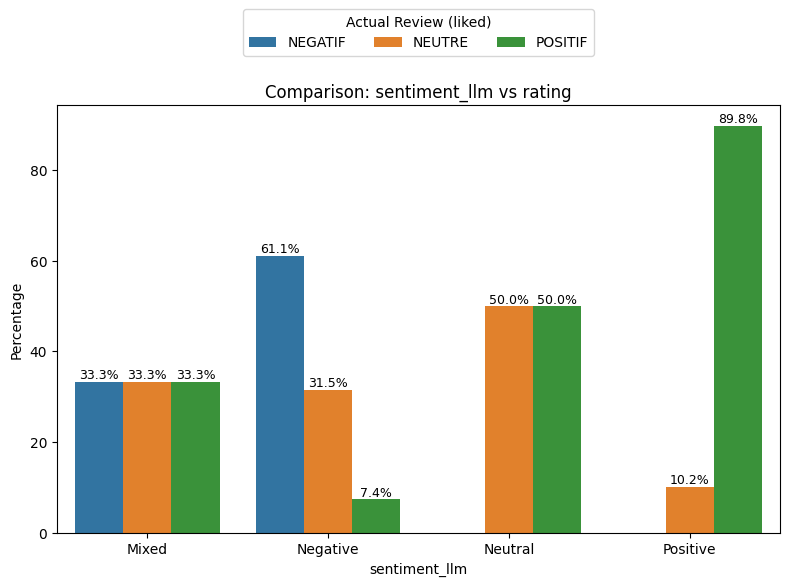

In [297]:
df_refults_filtered = df5_sample.copy()

# Group and compute percentages
rates = df_refults_filtered.groupby(['sentiment_llm', 'liked']).size().unstack().fillna(0)
rates = rates.div(rates.sum(axis=1), axis=0) * 100

# Convert to long format
rates_long = rates.reset_index().melt(id_vars='sentiment_llm', value_name='percentage', var_name='liked')

# Barplot
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=rates_long, x='sentiment_llm', y='percentage', hue='liked')

# Add percentage labels on top of bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.1f}%',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9)

plt.title('Comparison: sentiment_llm vs rating')
plt.xlabel('sentiment_llm')
plt.ylabel('Percentage')
plt.legend(title='Actual Review (liked)', loc='lower center', bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# travail annex pour trouver les thématiques

rappel : les reviews ont été cleanés tokenisés par par cett fonction :

def clean_review(review):
    review = review.lower()
    review = re.sub(r'[^a-zA-Z\s]', '', review) # retirer les caractères spéciaux
    review = re.sub(r'\s+', ' ', review).strip() # retirer les espaces
    review = re.sub(r'http\S+|www\S+', '', review) # retirer les URLs

    stop_words = set(stopwords.words('english'))
    review_tokens = nltk.word_tokenize(review) #methode de tokenisation efficace pour le langage courant (contractions de mots, ponctuation...)
    mot_a_sup = ["mcdonalds", "one"] #mots trop fréquents dans les commentaires
    stop_words.update(mot_a_sup)
    review = ' '.join([word for word in review_tokens if word not in stop_words])

   
    return review

In [298]:
df2['word_list'] = df2['clean_reviews_tokenised'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df2['word_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(20), columns=['Common_words', 'count'])

top_words_df.style.background_gradient(cmap='Blues')

,Common_words,count
0,food,5554
1,service,4592
2,order,3966
3,good,3516
4,place,2456
5,get,2227
6,fast,2081
7,drive,1851
8,like,1786
9,time,1754


In [299]:
Positive_sent = df2[df2['sentiment_SIA'] == 'positive']
Negative_sent = df2[df2['sentiment_SIA'] == 'negative']

top = Counter([item for sublist in df2[df2['sentiment_SIA'] == 'positive']['word_list'] for item in sublist])
positive_words = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
positive_words.style.background_gradient(cmap='Greens')

,Common_words,count
0,good,3054
1,food,2735
2,service,2289
3,great,1629
4,clean,1347
5,place,1306
6,order,1218
7,fast,1216
8,nice,1021
9,staff,1005


In [300]:
top = Counter([item for sublist in df2[df2['sentiment_SIA'] == 'negative']['word_list'] for item in sublist])
negative_words = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
negative_words.style.background_gradient(cmap='Reds')

,Common_words,count
0,order,1800
1,food,1522
2,service,1447
3,get,871
4,bad,781
5,place,719
6,rude,699
7,worst,685
8,drive,674
9,time,671
